In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import scipy.signal
import pickle
import multigoal
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Policy(object):
    def __init__(self, obs_dim, act_dim, kl_targ=0.01, clip_value=0.2, entcoeff=0.03,
                 max_std=0.01, epochs=10, lr=1e-4, n_mixture=4, hid_size=128,
                 weight_rule="sparsemax"):
        self.beta = 1.0  # dynamically adjusted D_KL loss multiplier
        self.kl_targ = kl_targ
        self.epochs = epochs
        self.lr = lr
        self.clip_value = clip_value
        self.entcoeff = entcoeff
        
        self.hid_size = hid_size
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.n_mixture = n_mixture
        self.max_std = max_std
        
        self.weight_rule = weight_rule
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        """ Build and initialize TensorFlow graph """
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._mdn_policy()
            self._logprob()
            self._kl_entropy()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        """ Input placeholders"""
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.advantages_ph = tf.placeholder(tf.float32, (None,), 'advantages')
        
        # strength of D_KL loss terms:
        self.beta_ph = tf.placeholder(tf.float32, (), 'beta')
        
        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
        # old policy params:
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.n_mixture, self.act_dim), 'old_mean')
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.n_mixture, self.act_dim), 'old_std')
        self.old_weight_ph = tf.placeholder(tf.float32, (None, self.n_mixture), 'old_weight')
        
        # value:
        self.val_ph = tf.placeholder(tf.float32, (None,), 'val_valfunc')        
        
    def _mdn_policy(self):
        
        hid1_size = self.hid_size  # 10 empirically determined
        hid2_size = self.hid_size
        
        with tf.variable_scope('policy_func'):
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="ph1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="ph2")
            means = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                    name="flat_mean")
            self.mean = tf.reshape(means,shape=[-1,self.n_mixture,self.act_dim], name="mean")
            self.logits_std = tf.layers.dense(out, self.act_dim*self.n_mixture,
                                         kernel_initializer=tf.random_normal_initializer(stddev=0.01), 
                                         name="flat_logits_std")
            self.std = tf.reshape(self.max_std*tf.sigmoid(self.logits_std),shape=[-1,self.n_mixture,self.act_dim], name="std")
            self.logits_weight = tf.layers.dense(out, self.n_mixture,
                                             kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                             name="logits_weight")
            if self.weight_rule == "softmax":
                self.weight = tf.nn.softmax(self.logits_weight,name="weight")
            elif self.weight_rule == "sparsemax":
                self.weight = tf.contrib.sparsemax.sparsemax(self.logits_weight,name="weight")

        with tf.variable_scope('value_func'):
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="vh1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01), name="vh2")
            value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                                    name="value")
            self.value = tf.squeeze(value)
            
    def _logprob(self):
        y = self.act_ph 
        mean = self.mean
        std = self.std
        weight = self.weight
        
        quadratics = -0.5*tf.reduce_sum(tf.square((tf.tile(y[:,tf.newaxis,:],[1,self.n_mixture,1])-mean)/std),axis=2)
        logdet = -0.5*tf.reduce_sum(tf.log(std),axis=2)
        logconstant = - 0.5*self.act_dim*np.log(2.*np.pi)
        logpi = tf.log(weight + 1e-10)
        
        exponents = quadratics + logdet + logconstant + logpi
        logprobs = tf.reduce_logsumexp(exponents,axis=1)
        
        self.logp = logprobs

        old_mean = self.old_mean_ph
        old_std = self.old_std_ph
        old_weight = self.old_weight_ph
    
        old_quadratics = -0.5*tf.reduce_sum(tf.square((tf.tile(y[:,tf.newaxis,:],[1,self.n_mixture,1])-old_mean)/old_std),axis=2)
        old_logdet = -0.5*tf.reduce_sum(tf.log(old_std),axis=2)
        old_logconstant = - 0.5*self.act_dim*np.log(2.*np.pi)
        old_logpi = tf.log(old_weight + 1e-10)
        
        old_exponents = old_quadratics + old_logdet + old_logconstant + old_logpi
        old_logprobs = tf.reduce_logsumexp(old_exponents,axis=1)
        
        self.logp_old = old_logprobs
    
    def _kl_entropy(self):
        std = self.std
        old_std = self.old_std_ph
        
        weight = self.weight
        old_weight = self.old_weight_ph
  
        if self.weight_rule == "softmax":
            self.kl = tf.reduce_sum(old_weight*tf.log(old_weight/weight)
                                    + old_weight*0.5*(tf.reduce_sum(tf.log(std)-tf.log(old_std) + tf.square(old_std/std) 
                                    + tf.square((self.mean - self.old_mean_ph)/std) - self.act_dim,axis=2)),axis=1)
            self.kl = tf.reduce_mean(self.kl)

            self.entropy = tf.reduce_sum(weight*(-tf.log(weight) + 0.5 * (self.act_dim * (np.log(2 * np.pi) + 1) +
                                  tf.reduce_sum(tf.log(std),axis=2))),axis=1)
            self.entropy = tf.reduce_mean(self.entropy)
        elif self.weight_rule == "sparsemax":
            
            def energy(mu1,std1,pi1,mu2,std2,pi2):
                energy_components = []
                for i in range(self.n_mixture):
                    for j in range(self.n_mixture):
                        mu1i = tf.squeeze(mu1[:,i,:]) 
                        mu2j = tf.squeeze(mu2[:,j,:])
                        std1i = tf.squeeze(std1[:,i,:])
                        std2j = tf.squeeze(std2[:,j,:])
                        pi1i = pi1[:,i]
                        pi2j = pi2[:,j]        
                        energy_components.append(pi1i*pi2j * tf.exp(-0.5*tf.reduce_sum(((mu1i - mu2j)/(std1i+std2j))**2+2.*tf.log(std1i+std2j)+np.log(2*np.pi),axis=1)))
                return tf.reduce_sum(tf.stack(energy_components),axis=1) 
            
            
            mean, std, weight = self.mean, self.std, self.weight
            old_mean, old_std, old_weight = self.old_mean_ph, self.old_std_ph, self.old_weight_ph
            
            self.kl = tf.reduce_mean(energy(mean, std, weight,mean, std, weight) 
                                     - 2*energy(mean, std, weight,old_mean, old_std, old_weight) 
                                     + energy(old_mean, old_std, old_weight,old_mean, old_std, old_weight))/8.
            self.entropy = tf.reduce_mean(0.5*(1-energy(mean, std, weight,mean, std, weight)))
            

    def _loss_train_op(self):
        
        ratio = tf.exp(self.logp - self.logp_old)
        cliped_ratio = tf.clip_by_value(ratio,clip_value_max=1.+self.clip_value,clip_value_min=1.-self.clip_value)
        surrloss = -tf.reduce_mean(tf.minimum(ratio*self.advantages_ph,cliped_ratio*self.advantages_ph))
        
        val_loss = 0.5*tf.square(self.val_ph - self.value)
        self.val_loss = tf.reduce_mean(val_loss)
        
        self.loss = surrloss - self.entcoeff*self.entropy + self.val_loss
        self.loss_p = -tf.reduce_mean(self.logp)
        
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_rl_op = optimizer.minimize(self.loss)
        self.train_reg_op = optimizer.minimize(self.loss_p)

    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def predict(self, obs):
        feed_dict = {self.obs_ph: obs}
        v_pred = self.sess.run(self.value,feed_dict=feed_dict)
        return np.squeeze(v_pred)
        
    def sample(self, obs):
        feed_dict = {self.obs_ph: obs}
        pi, mu, sigma = self.sess.run([self.weight, self.mean, self.std],feed_dict=feed_dict)
        
        n_points = np.shape(obs)[0]
        
        _y_sampled = np.zeros([n_points,self.act_dim])
        for i in range(n_points):
            k = np.random.choice(self.n_mixture,p=pi[i,:])
            _y_sampled[i,:] = mu[i,k,:] + np.random.randn(1,self.act_dim)*sigma[i,k,:]
        return _y_sampled
    
    def rlupdate(self, observes, actions, advantages, tdlamret, batch_size = 128):
        
        num_batches = max(observes.shape[0] // batch_size, 1)
        batch_size = observes.shape[0] // num_batches
        
        old_mean_np, old_std_np, old_weight_np = self.sess.run([self.mean, self.std, self.weight],{self.obs_ph: observes})
        loss, kl, entropy = 0, 0, 0
        for e in range(self.epochs):
            observes, actions, advantages, tdlamret, old_mean_np, old_std_np, old_weight_np = shuffle(observes, actions, advantages, tdlamret, old_mean_np, old_std_np, old_weight_np)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: observes[start:end,:],
                     self.act_ph: actions[start:end,:],
                     self.advantages_ph: advantages[start:end],
                     self.old_std_ph: old_std_np[start:end,:,:],
                     self.old_mean_ph: old_mean_np[start:end,:,:],
                     self.old_weight_ph: old_weight_np[start:end,:],
                     self.beta_ph: self.beta,
                     self.lr_ph: self.lr,
                     self.val_ph: tdlamret[start:end]}        
                kl,_ = self.sess.run([self.kl, self.train_rl_op], feed_dict)
            
                if kl > self.kl_targ * 1.5:  # servo beta to reach D_KL target
                    self.beta = 2 * self.beta
                elif kl < self.kl_targ / 1.5:
                    self.beta = self.beta / 2
                
        feed_dict = {self.obs_ph: observes,
             self.act_ph: actions,
             self.advantages_ph: advantages,
             self.old_std_ph: old_std_np,
             self.old_mean_ph: old_mean_np,
             self.old_weight_ph: old_weight_np,
             self.beta_ph: self.beta,
             self.lr_ph: self.lr,
             self.val_ph: tdlamret}
        loss, kl, entropy, vf_loss = self.sess.run([self.loss, self.kl, self.entropy, self.val_loss], feed_dict)
        return loss, kl, entropy, vf_loss
        
    def regupdate(self, x, y, batch_size=128):
        num_batches = max(x.shape[0] // batch_size, 1)
        batch_size = x.shape[0] // num_batches
        
        x_train = x
        y_train = y
        for e in range(self.epochs):
            x_train, y_train = shuffle(x_train, y_train)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: x_train[start:end, :],
                             self.act_ph: y_train[start:end, :],
                             self.lr_ph: self.lr}
                self.sess.run(self.train_reg_op, feed_dict=feed_dict)
        feed_dict = {self.obs_ph: x_train, self.act_ph: y_train, self.lr_ph: self.lr}
        loss_p = self.sess.run(self.loss_p, feed_dict=feed_dict)
        return loss_p
    
    def save_policy(self, path):
        saver = tf.train.Saver(self.variables)
        saver.save(self.sess, path+'/mdn'+str(self.n_mixture)+'_bc_policy.ckpt')

    def close_sess(self):
        self.sess.close()

In [ ]:

def discount(x, gamma):
    """ Calculate discounted forward sum of a sequence at each point """
    return scipy.signal.lfilter([1.0], [1.0, -gamma], x[::-1])[::-1]


def add_disc_sum_rew(trajectories, gamma):
    for trajectory in trajectories:
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        disc_sum_rew = discount(rewards, gamma)
        trajectory['disc_sum_rew'] = disc_sum_rew

def add_rew(trajectories):
    for trajectory in trajectories:
        trajectory['rewards'] = trajectory['true_rewards']

def add_value(trajectories, val_func):
    for trajectory in trajectories:
        observes = trajectory['observes']
        trajectory['values'] = val_func.predict(observes)

def add_gae(trajectories, gamma, lam):
    for trajectory in trajectories:
        if gamma < 0.999:  # don't scale for gamma ~= 1
            rewards = trajectory['rewards'] * (1 - gamma)
        else:
            rewards = trajectory['rewards']
        values = trajectory['values']
        # temporal differences
        tds = rewards - values + np.append(values[1:] * gamma, 0)
        trajectory['tdlamret'] = tds
        advantages = discount(tds, gamma * lam)
        trajectory['advantages'] = advantages

def build_train_set(trajectories):
    """
    Args:
        trajectories: trajectories after processing by add_disc_sum_rew(),
            add_value(), and add_gae()
    Returns: 4-tuple of NumPy arrays
        observes: shape = (N, obs_dim)
        actions: shape = (N, act_dim)
        advantages: shape = (N,)
        disc_sum_rew: shape = (N,)
    """
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    tdlamret = np.concatenate([t['tdlamret'] for t in trajectories])
    advantages = np.concatenate([t['advantages'] for t in trajectories])
    # normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

    return observes, actions, advantages, tdlamret

def run_episode(env, policy, animate=False):
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        if animate:
            env.render()
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        action = policy.sample(obs).reshape((1, -1)).astype(np.float32)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype=np.float32), infos)


def run_policy(env, policy, episodes):
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, policy)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'true_rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

def evaluation(env, policy, max_eval_epi=100, seed=0):
    return_list = np.zeros((max_eval_epi,))
    info_list = []

    env.seed(seed)
    for epi in range(max_eval_epi):
        obs = env.reset()
        env_infos_epi_list = {"pos": [],"goal_id": []}
        observes, actions, rewards, infos = run_episode(env, policy)

        pos_list = []
        goal_id_list = []
        for info in infos:
            pos_list.append(info["pos"])
            goal_id_list.append(info["goal_id"])
        env_infos_epi_list["pos"] = np.asarray(pos_list)
        env_infos_epi_list["goal_id"] = np.asarray(goal_id_list)

        info_list.append({"env_infos":env_infos_epi_list})
        return_list[epi] = np.sum(rewards)
#     print("Evaluation Result: {}".format(np.mean(return_list)))
    return return_list, info_list

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


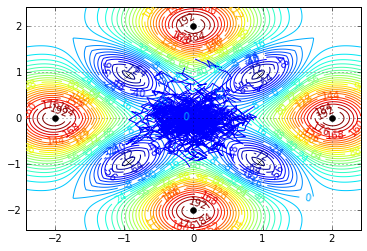

*** Mean Ret : -46.037, Value Loss : 0.00120, Policy loss : 20.58246, Policy KL : 0.004, Policy Entropy : -205.806 ***


In [ ]:
env = multigoal.MultiGoalEnv(nr_goal=4)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
kl_targ = 0.01
gamma = 0.995
lam = 0.98

policy = Policy(obs_dim,act_dim,kl_targ,clip_value=0.01,weight_rule="sparsemax",entcoeff=1e-1,max_std=0.5,lr=1e-4,n_mixture=4)

episode_size = 500
nupdates = 500

for update in range(nupdates+1):
    trajectories = run_policy(env, policy, episodes=episode_size)
    add_rew(trajectories)
    add_value(trajectories, policy)  # add estimated values to episodes
    add_disc_sum_rew(trajectories, gamma)  # calculated discounted sum of Rs
    add_gae(trajectories, gamma, lam)  # calculate advantage
    observes, actions, advantages, tdlamret = build_train_set(trajectories)

    pol_loss, pol_kl, pol_entropy, vf_loss = policy.rlupdate(observes, actions, advantages, tdlamret, batch_size=64)  # update policy
    if (update%10) == 0:
        return_list, info_list = evaluation(env, policy, max_eval_epi=100)
        env.plot_paths(info_list)
        plt.show()
        plt.pause(0.005)
        
        mean_ret = np.mean([np.sum(t['true_rewards']) for t in trajectories])
        print('*** Mean Ret : {:.3f}, Value Loss : {:.5f}, Policy loss : {:.5f}, Policy KL : {:.3f}, Policy Entropy : {:.3f} ***'
              .format(mean_ret, vf_loss, pol_loss, pol_kl, pol_entropy))